In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
# Import the necessary module to display and handle HTML content
from IPython.display import display, HTML

# Embeds a hyperlink in the notebook to open the notebook in Google Colab
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
# Check if the code is being run in Google Colab

if using_colab:
    # import necessary libraries
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    # import system specific parameters and functions
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

NameError: name 'using_colab' is not defined

## Set-up

In [6]:
%pip install torch torchvision torchaudio
%pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Using cached torch-2.0.1-cp38-none-macosx_10_9_x86_64.whl (143.1 MB)
  Using cached torchvision-0.15.2-cp38-cp38-macosx_10_9_x86_64.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 5.3 MB/s eta 0:00:0000:0100:01
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached filelock-3.12.0-py3-none-any.whl (10 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached Pillow-9.5.0-cp38-cp38-macosx_10_10_x86_64.whl (3.4 MB)
  Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached MarkupSafe-2.1.2-cp38-cp38-macosx_10_9_x86_64.whl (13 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-2.0.2-py3-none-any.whl (123 kB)
  Using cached charset_normalizer-3.1.0-cp38-cp38-macosx_10_9_x86_64.whl (123 kB)
  Using cached certifi-2023.5.7-py3-none-any.whl (156 kB)
  Using cached mpmath-1.3.0-py3-no

In [3]:
# Import numpy for numerical computation, torch for deep learning, matplotlib for plotting, and OpenCV for image processing
import numpy as np
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
# Define a function to display the segmentations (annotations)
def show_anns(anns):
    # If there are no annotations, return immediately
    if len(anns) == 0:
        return
    
    # Sort the annotations by area in descending order
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    # Set up the plot using Matplotlib
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create an image placeholder with the same shape as the segmentation map
    # The fourth channel is for alpha (transparency)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0  # Set the alpha channel to 0 (transparent)
    
    # For each annotation in the sorted list
    for ann in sorted_anns:
        # Get the segmentation map
        m = ann['segmentation']
        # Create a color mask with random colors and a fixed alpha value
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # Apply the color mask to the segments identified in the image
        img[m] = color_mask
    # Display the image with the colored segmentations
    ax.imshow(img)

## Example image

In [5]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

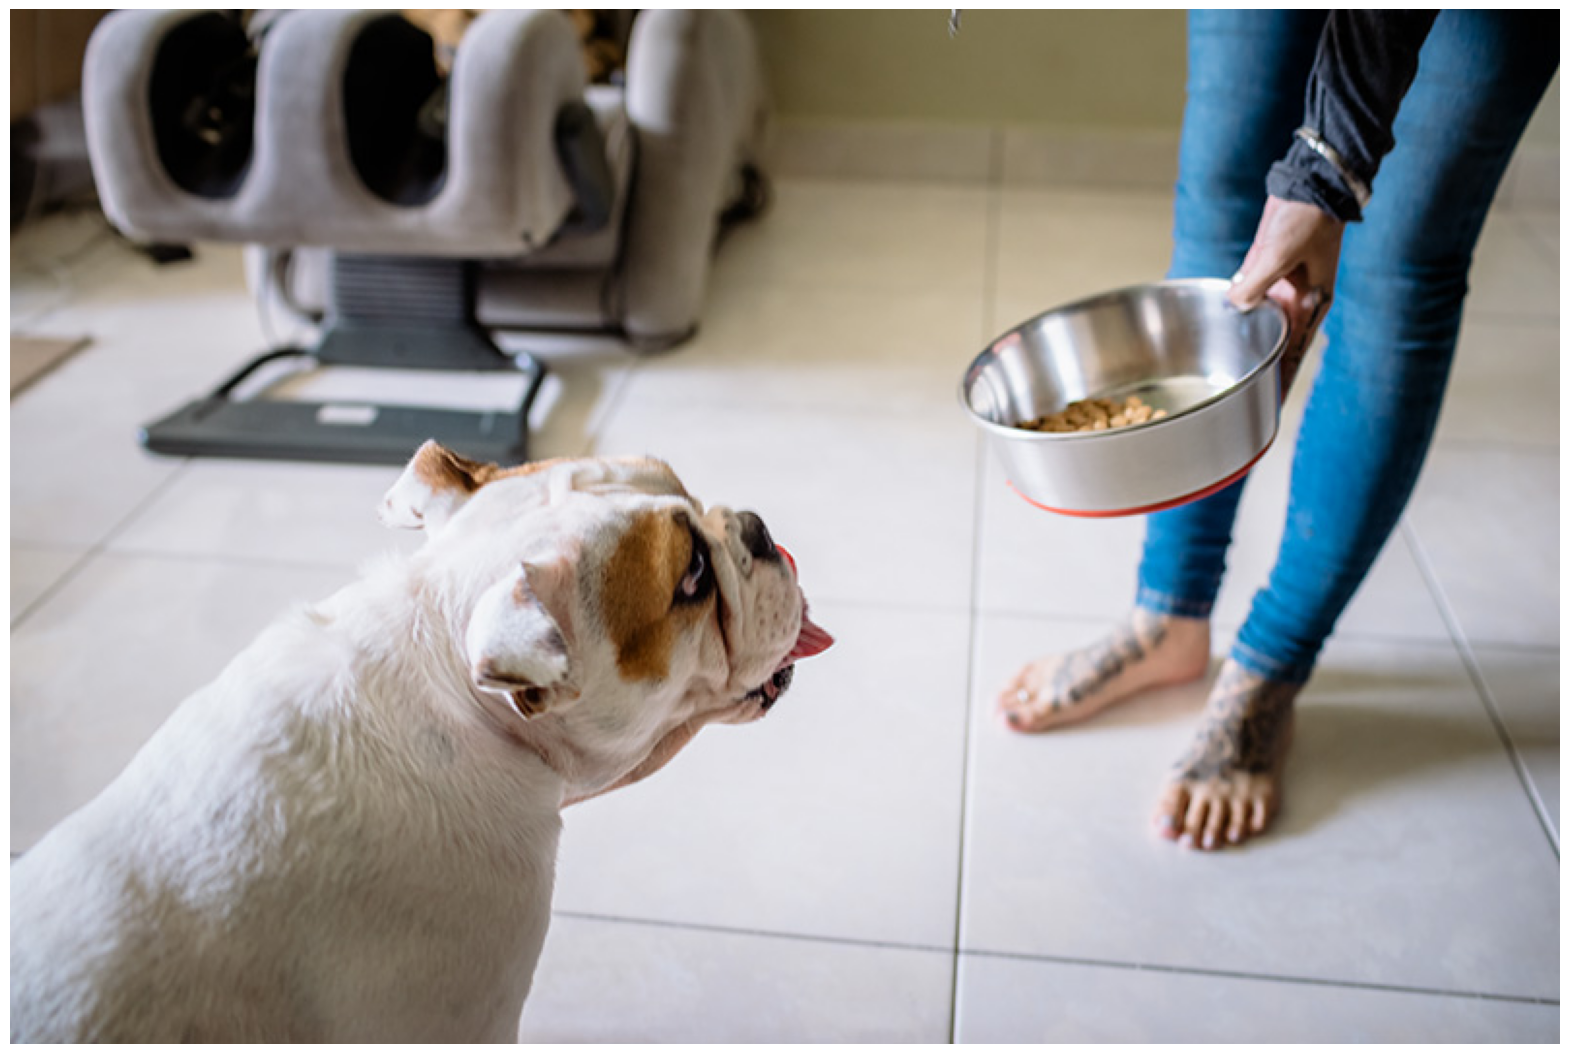

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/adrian/Desktop/cs-projects/segment-anything/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu" 

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [56]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [57]:
print(len(masks))
print(masks[0].keys())

44
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

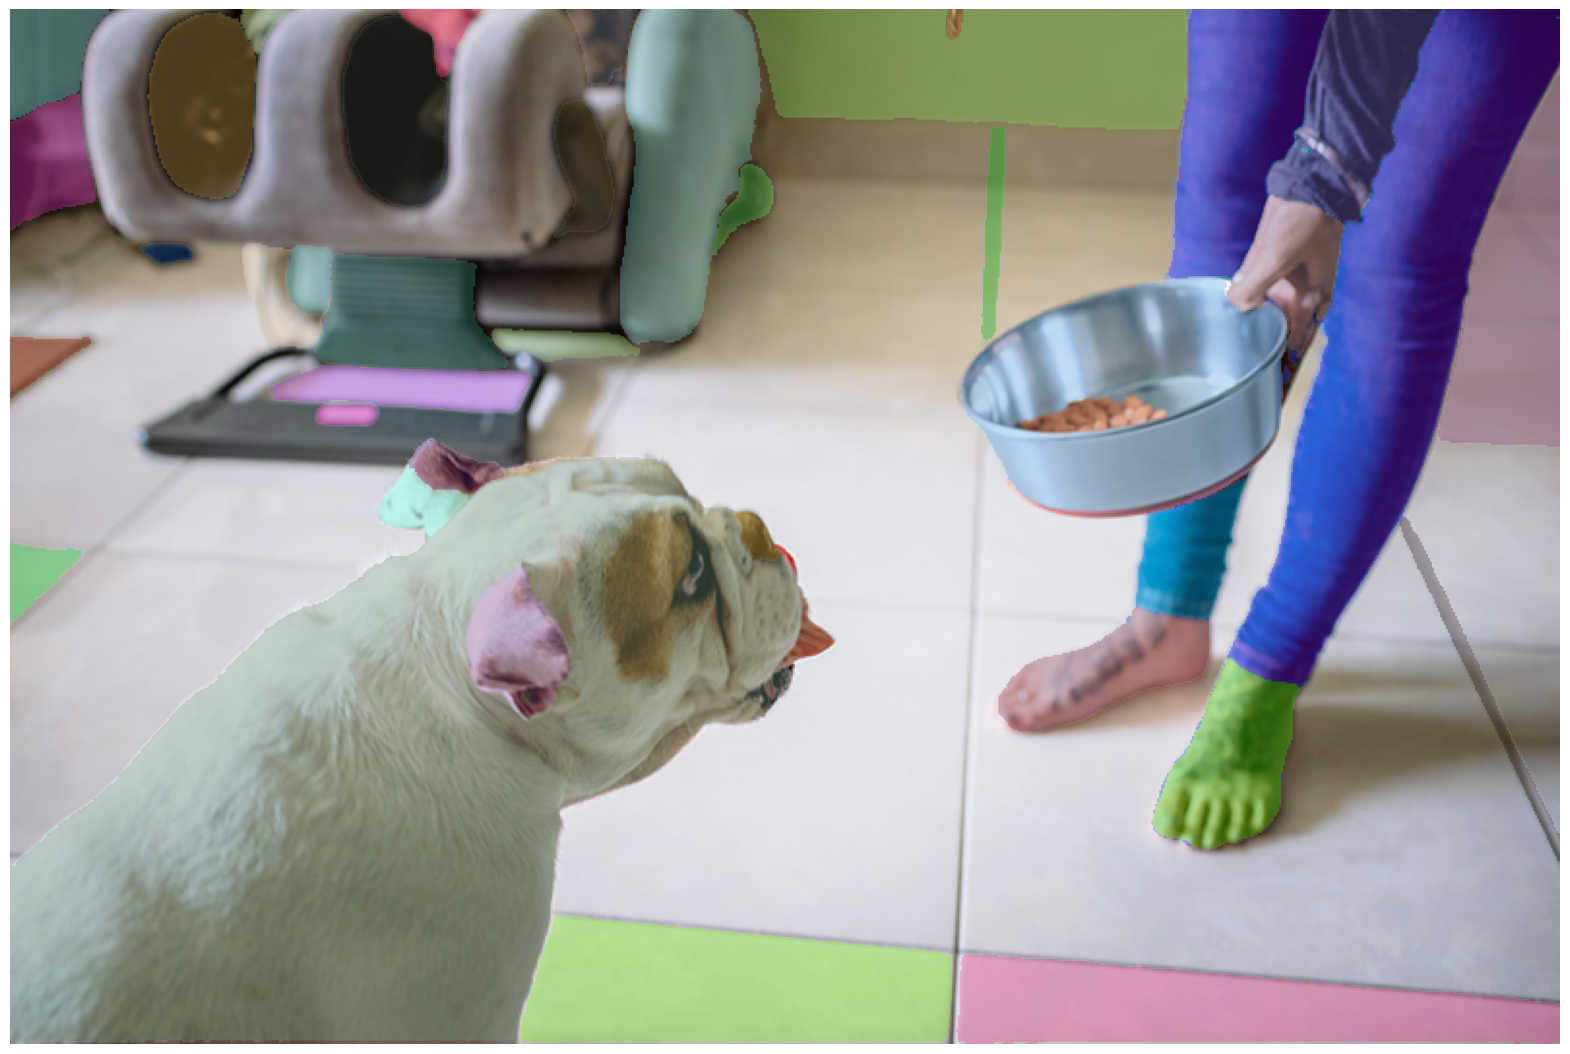

In [58]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [20]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# 64 segments

In [24]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=24,
    pred_iou_thresh=0.75,
    stability_score_thresh=0.85,
    crop_n_layers=0,
    crop_n_points_downscale_factor=3,
    min_mask_region_area=200,  # Requires open-cv to run post-processing
)

# 84 segments


In [59]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=0,
    crop_n_points_downscale_factor=4,
    min_mask_region_area=300,  # Requires open-cv to run post-processing
)
#23 segments


In [32]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.98,
    crop_n_layers=0,
    crop_n_points_downscale_factor=4,
    min_mask_region_area=500,  # Requires open-cv to run post-processing
)

# 1 segment


In [36]:
'''
points_per_side: Increasing this parameter will make the point sampling denser, 
which may lead to more precise and detailed masks. However, this can also lead to 
a more aggressive segmentation. To make segmentation less aggressive, you can consider 
decreasing this number.

pred_iou_thresh (Prediction Intersection over Union Threshold): This parameter is used 
to remove masks that overlap too much with others. Lowering this value would make the 
mask generation less aggressive as it will allow more overlapping among the generated masks.

stability_score_thresh: Lowering this threshold could result in less aggressive mask generation 
as it would permit masks that are less stable over different point samplings.

crop_n_layers: This controls how many times the image is automatically cropped for mask generation. 
Higher values would mean more aggressive segmentation. To decrease aggressiveness, consider reducing this number.

crop_n_points_downscale_factor: When an image is cropped, this parameter determines how much the 
number of points per side decreases. Higher values can result in less aggressive mask generation 
since fewer points would be sampled on cropped images.

min_mask_region_area: This parameter controls the minimum area a mask must have after post-processing 
to be kept. If you increase this number, it will remove smaller masks, resulting in less aggressive segmentation.
'''

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.96,
    crop_n_layers=0,
    crop_n_points_downscale_factor=4,
    min_mask_region_area=400,  # Requires open-cv to run post-processing
)

# 11 segments


In [92]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.5,
    crop_n_layers=0,
    crop_n_points_downscale_factor=4,
    min_mask_region_area=1000,  # Requires open-cv to run post-processing
)

#


In [9]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,  # More points should give more precise segmentations
    pred_iou_thresh=0.86,  # Increasing this means only keeping segmentations that are highly similar to the model's prediction
    stability_score_thresh=0.92,  # Increasing this means the segmentation must remain stable across different scales
    crop_n_layers=1,  # As you do not want any cropping, keeping this at 0
    crop_n_points_downscale_factor=2,  # If you are not using cropping, this value shouldn't matter
    min_mask_region_area=100,  # Increase this to ensure smaller 'random' segments are ignored
)


In [10]:
masks2 = mask_generator_2.generate(image)
len(masks2)

83

In [199]:
#Specify the minimum and maximum area value you want to filter by

h, w, _ = image.shape
min_area = 0.02 * h * w

new_dict = []

for i in masks2:
    if i['area'] > min_area:
        new_dict.append(i)

len(new_dict)

14

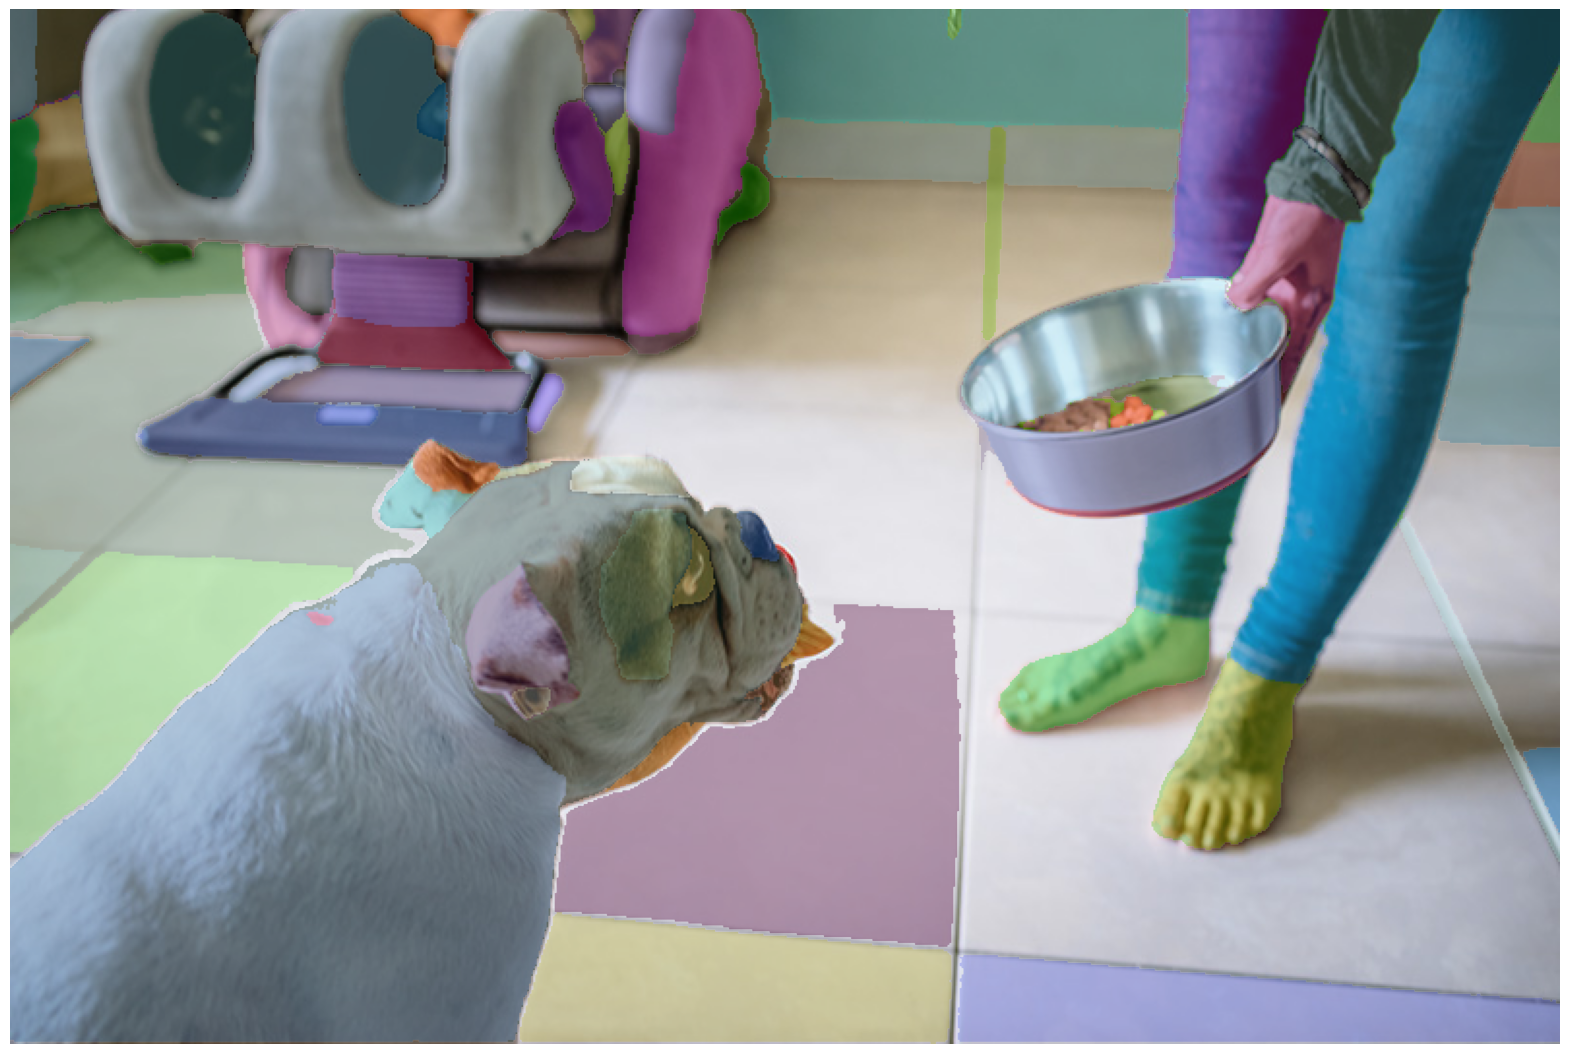

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

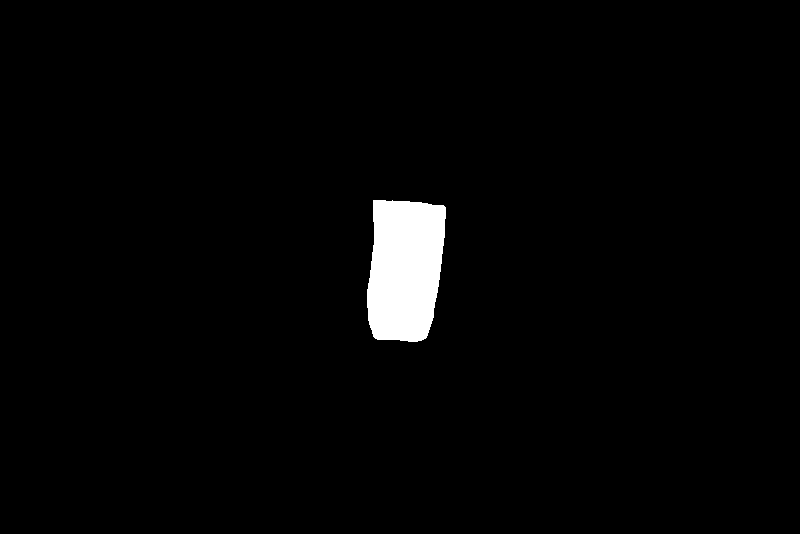

[367, 200, 78, 141]


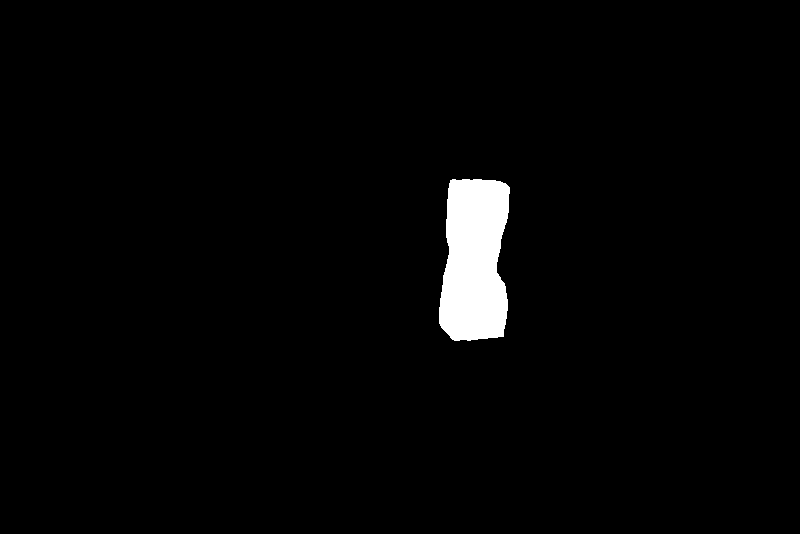

[439, 179, 70, 161]


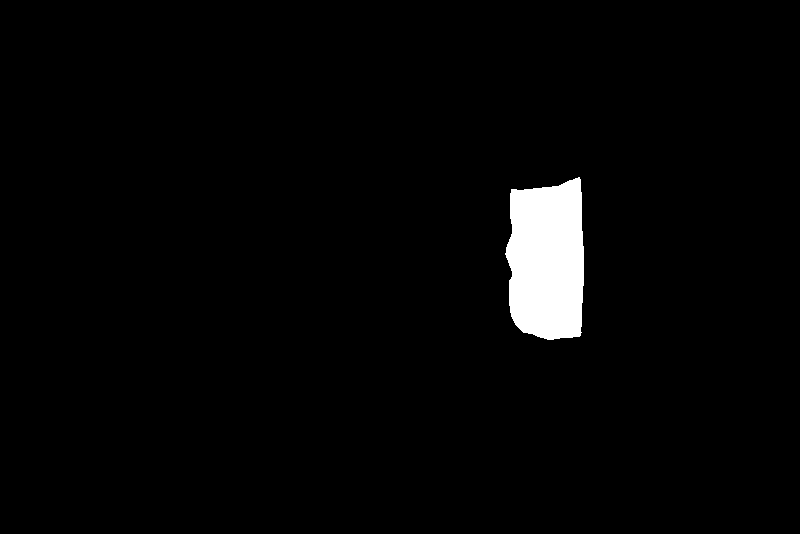

[505, 177, 78, 162]


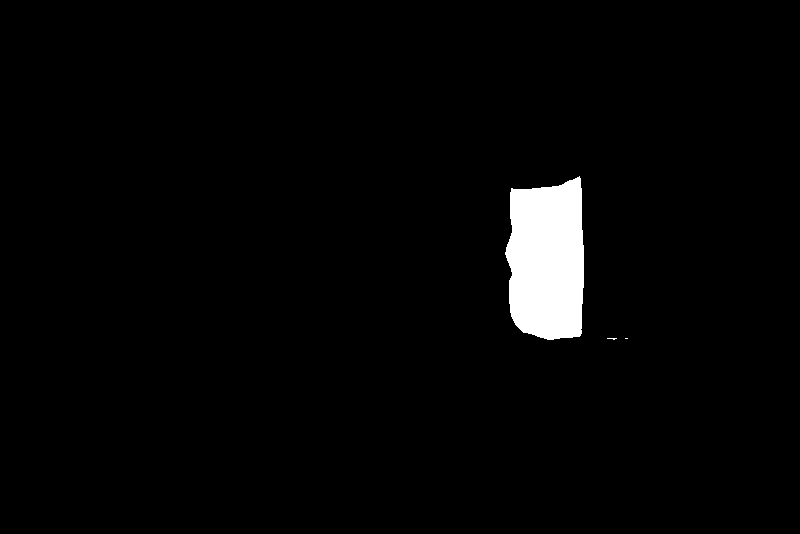

[505, 176, 122, 163]


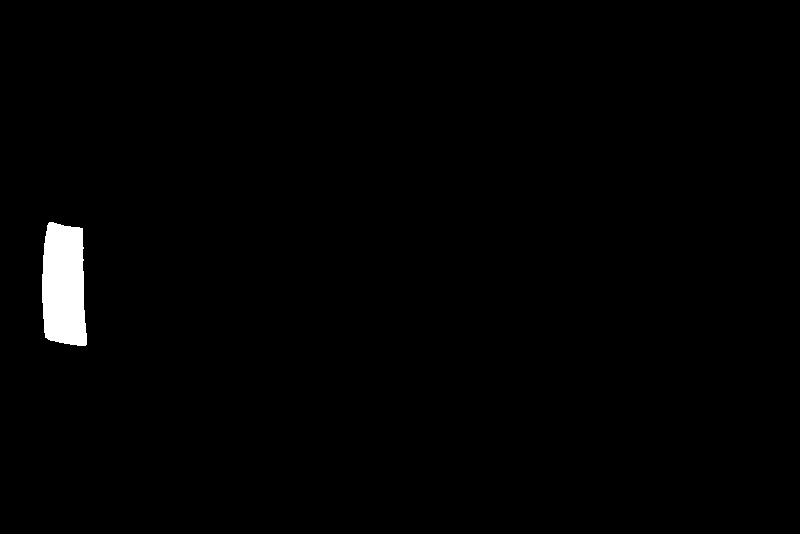

[42, 222, 44, 123]


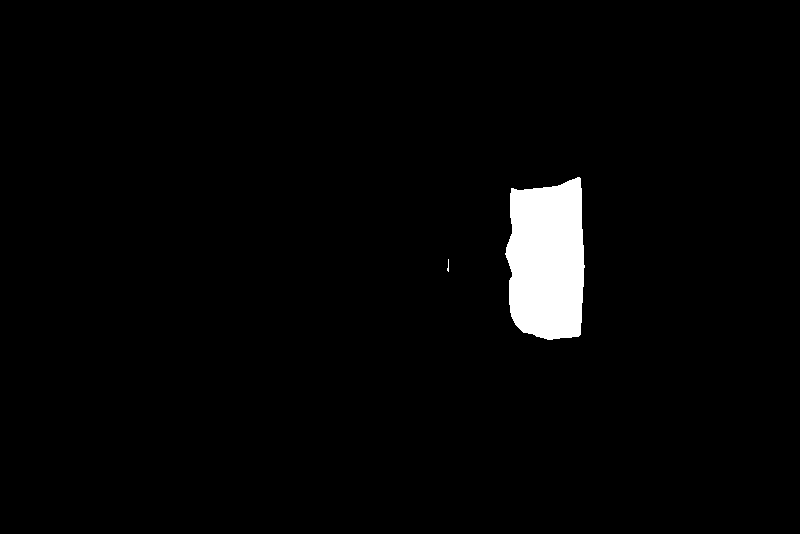

[447, 177, 137, 162]


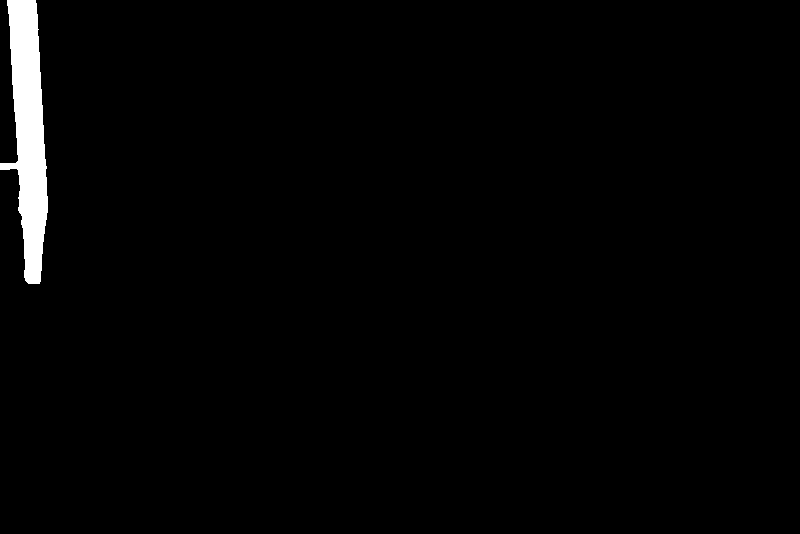

[0, 0, 47, 283]


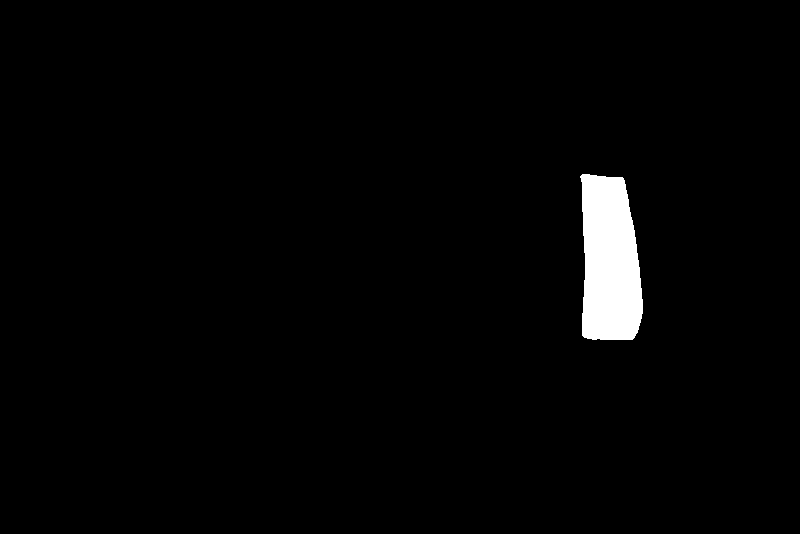

[580, 174, 62, 165]


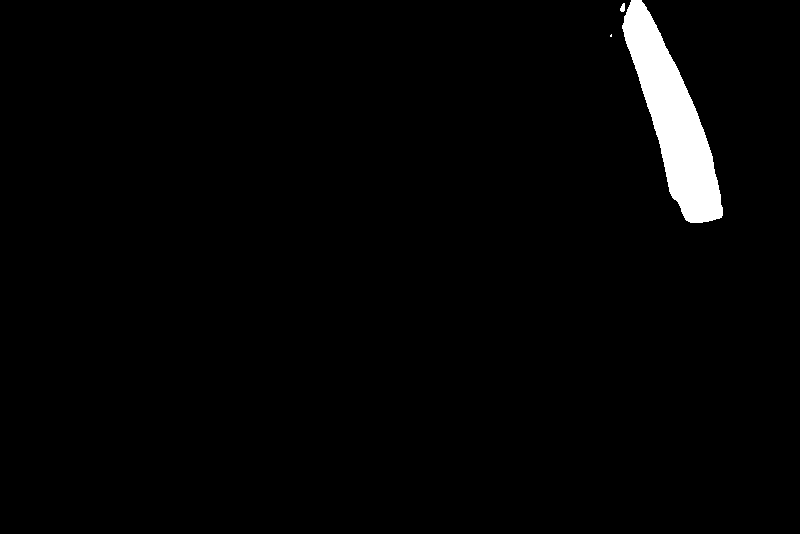

[610, 0, 112, 222]


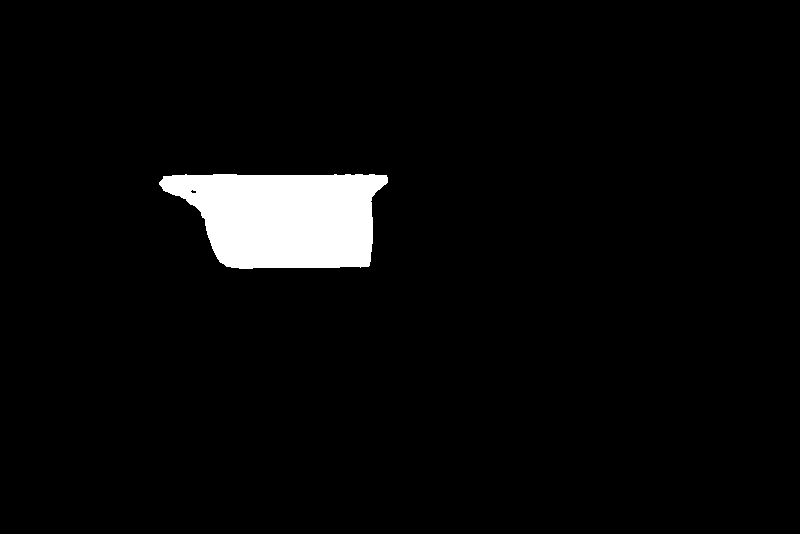

[159, 174, 228, 94]


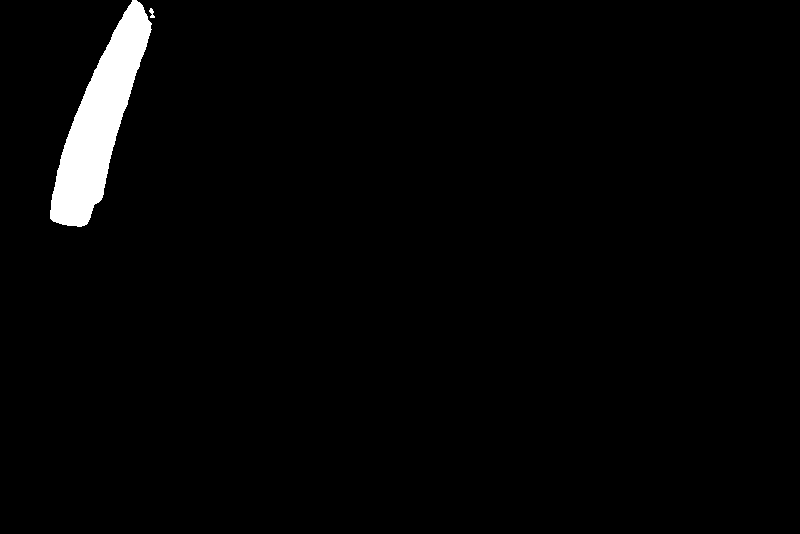

[50, 0, 104, 226]


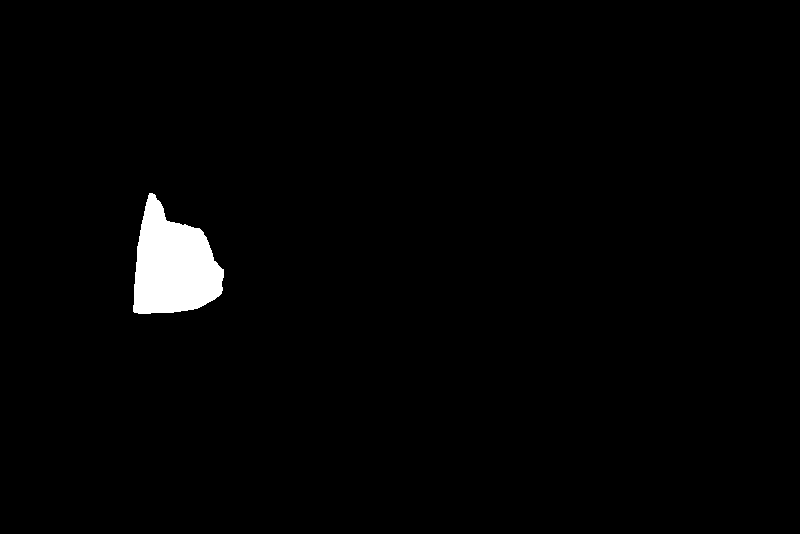

[133, 193, 90, 120]


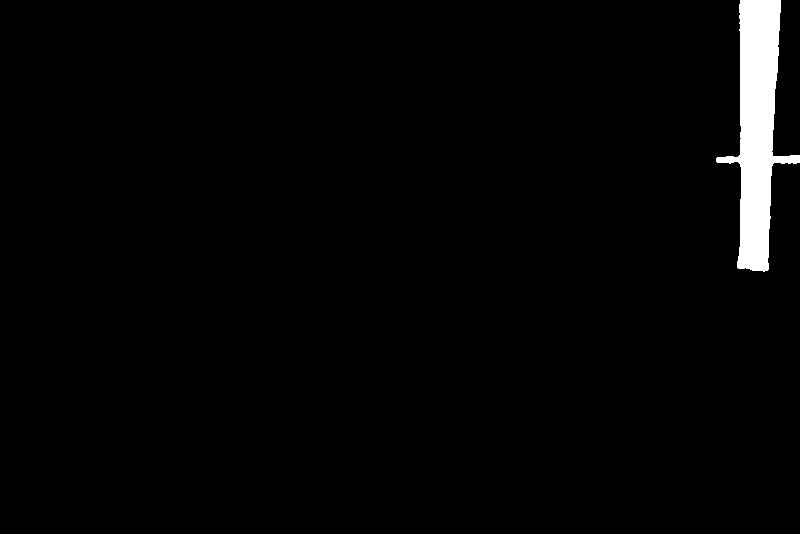

[716, 0, 83, 271]


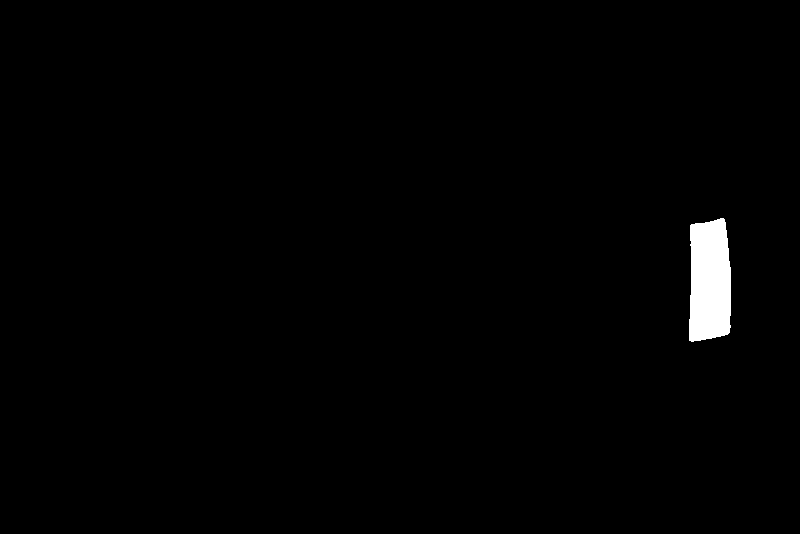

[689, 218, 41, 123]


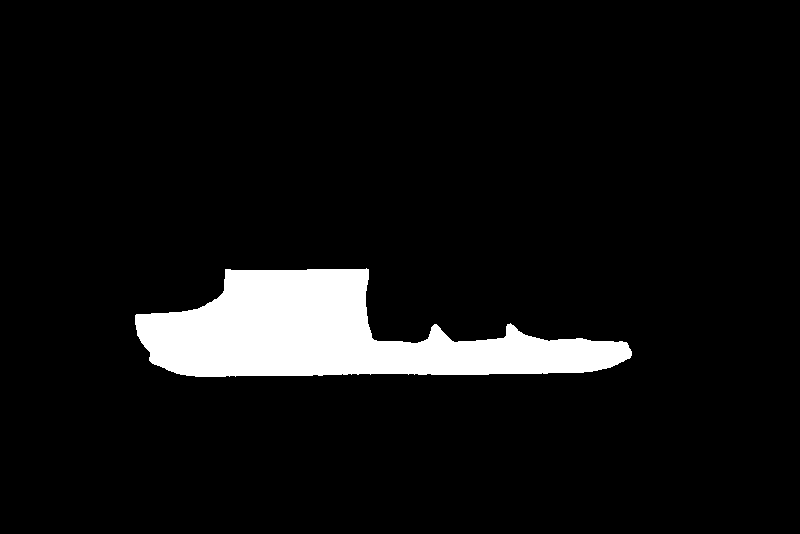

[135, 268, 496, 108]


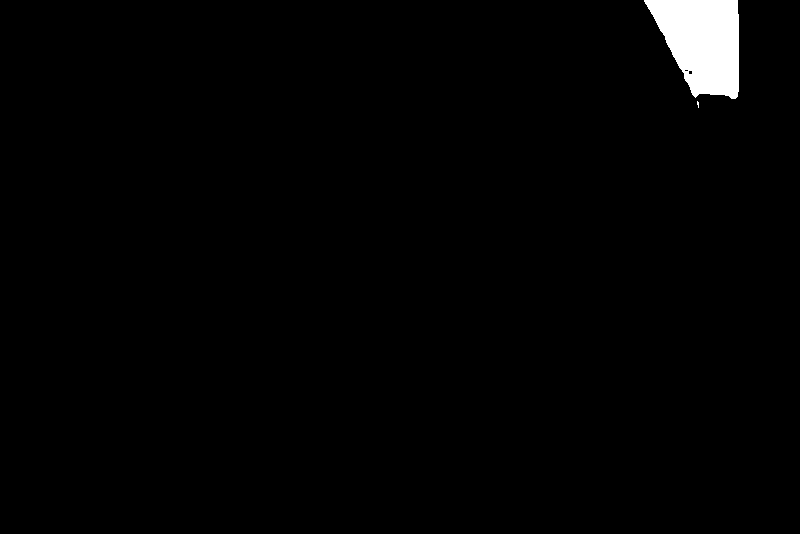

[644, 0, 94, 107]


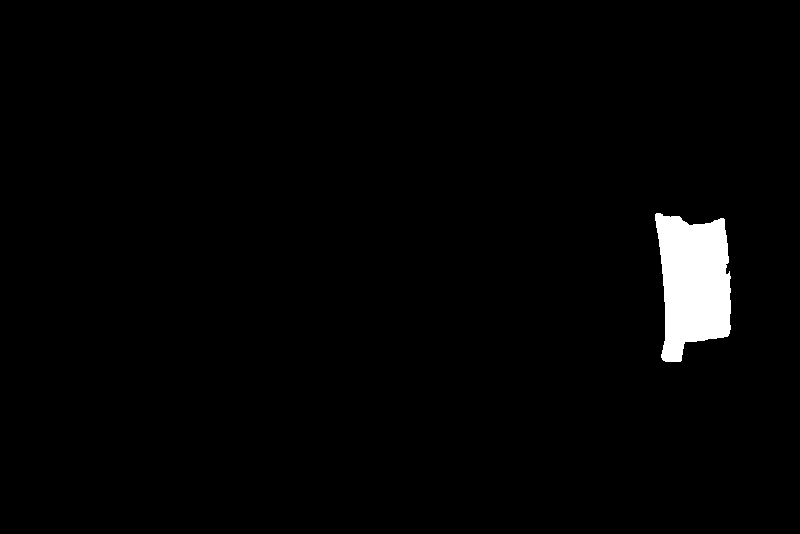

[655, 213, 75, 148]


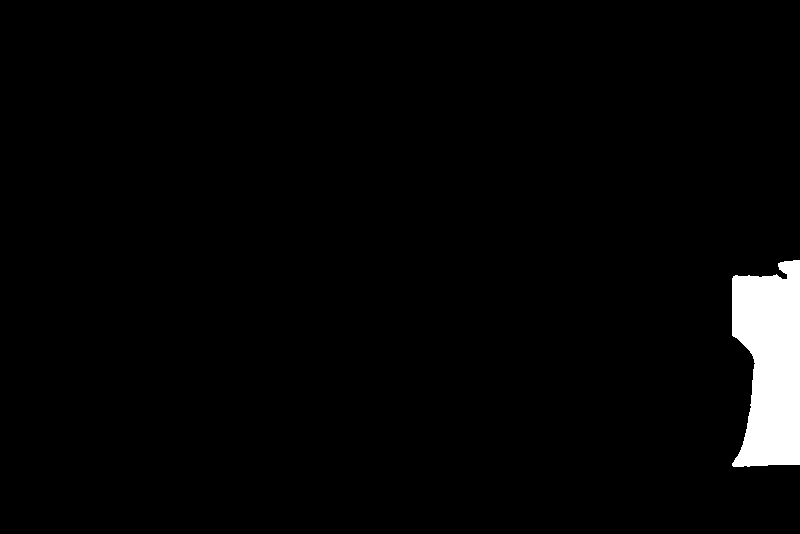

[732, 260, 67, 206]


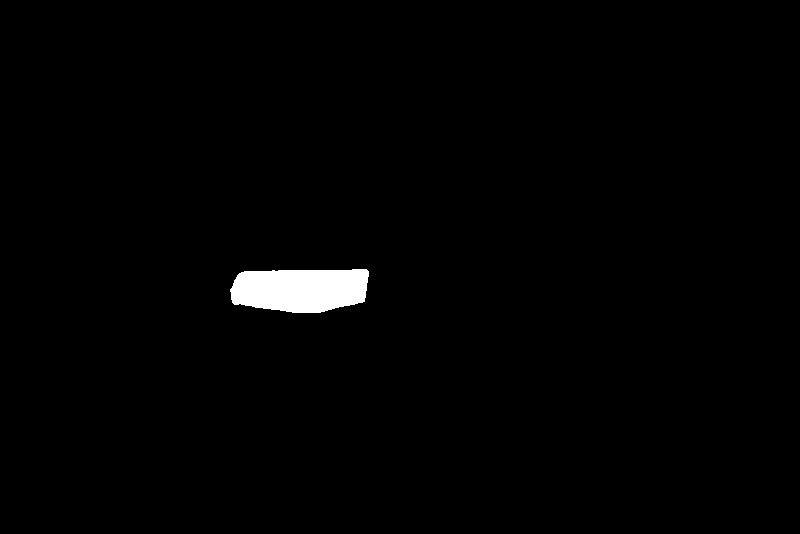

[230, 269, 138, 43]


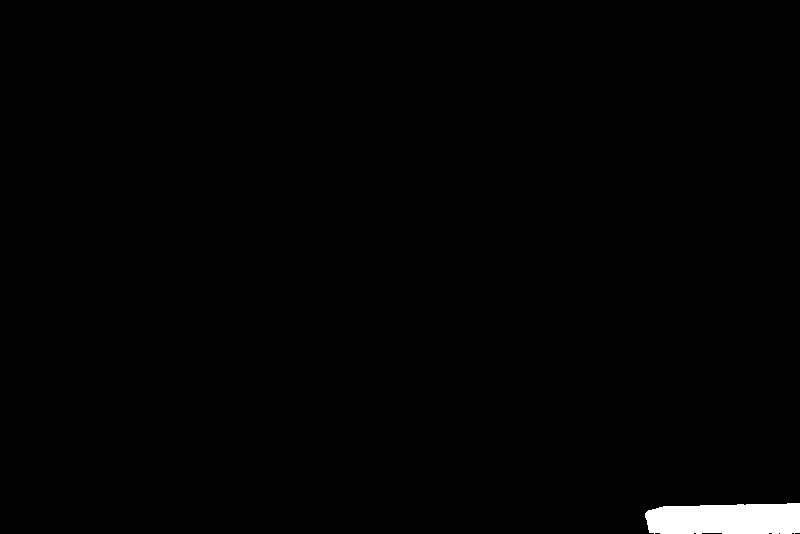

[645, 503, 154, 30]


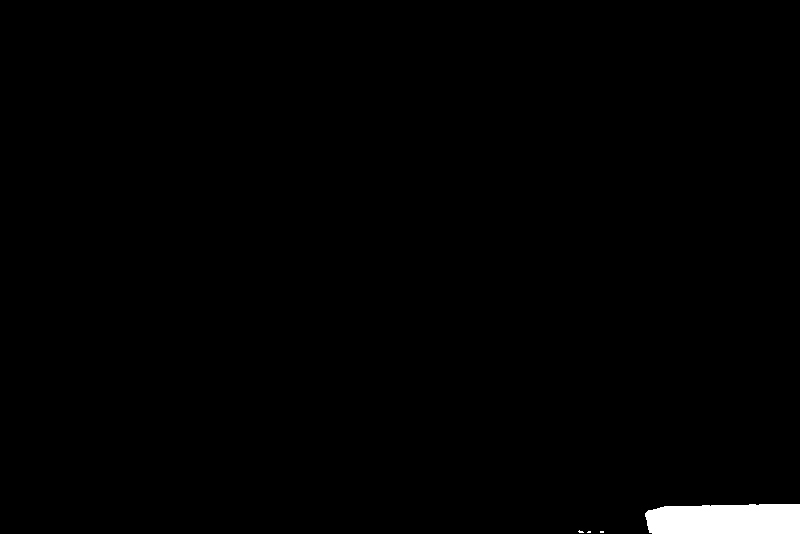

[578, 504, 221, 29]


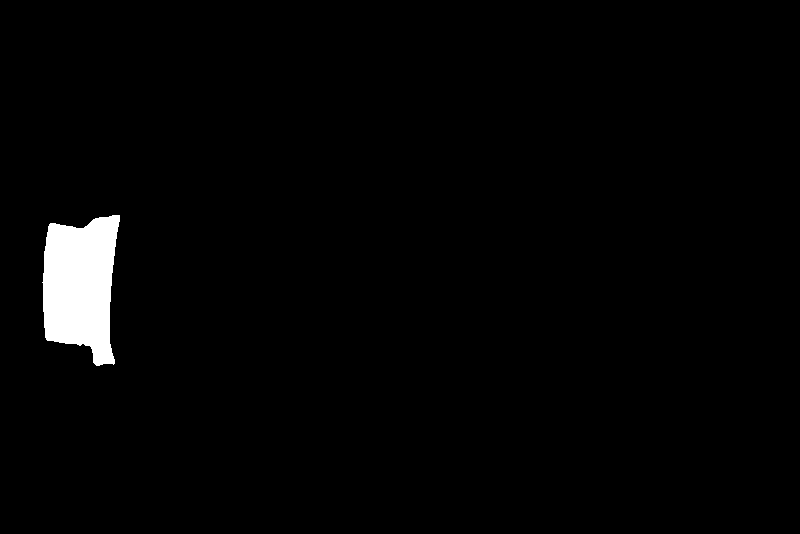

[42, 215, 77, 150]


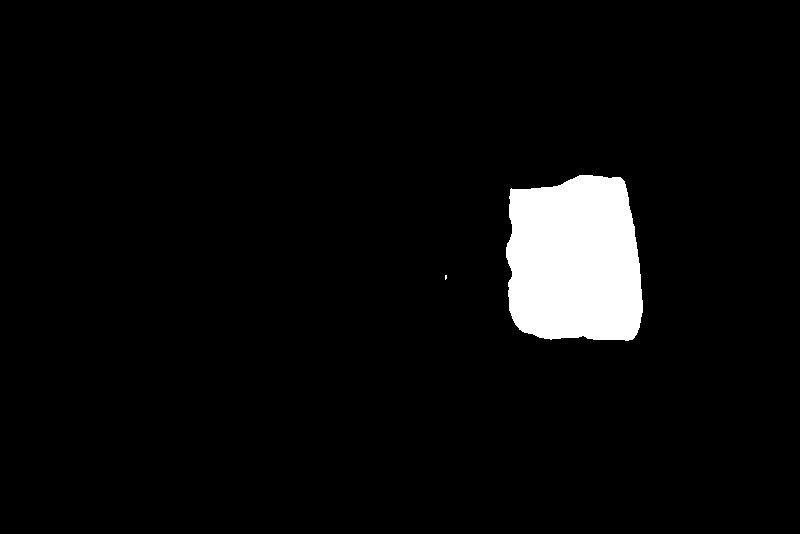

[445, 175, 197, 165]


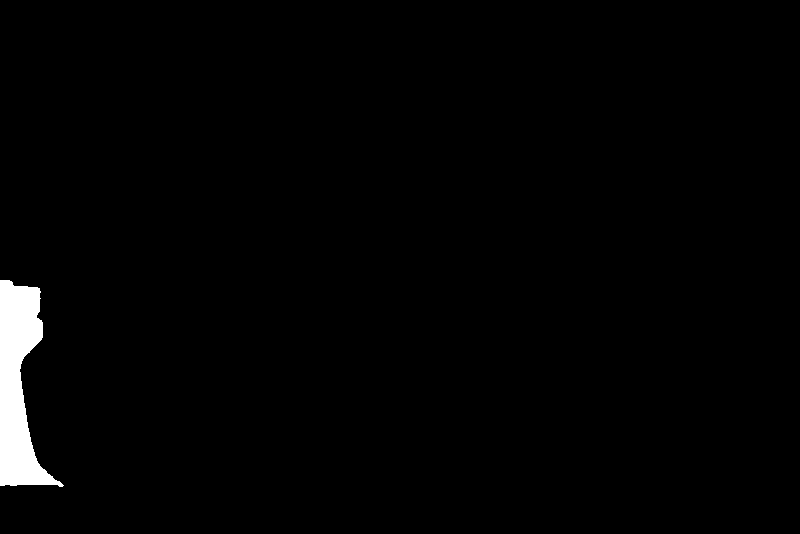

[0, 280, 63, 206]


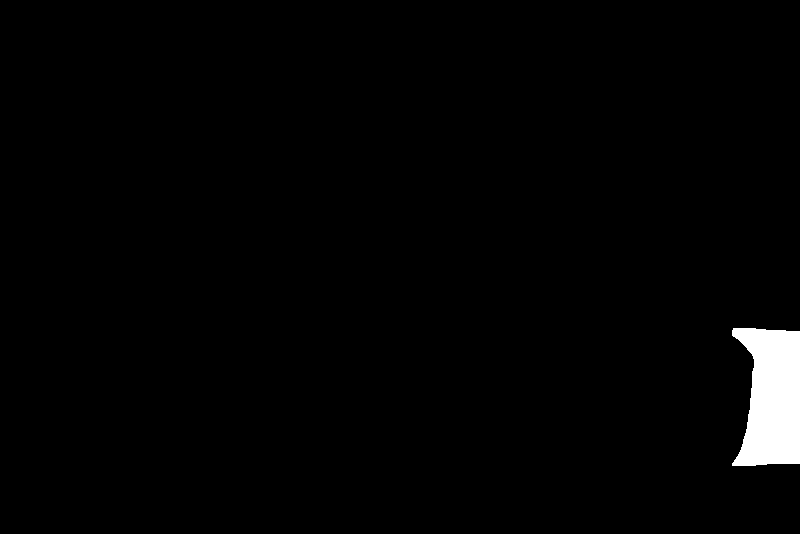

[732, 328, 67, 137]


In [198]:
from PIL import Image
image_tmp = Image.open('/Users/adrian/Desktop/cs-projects/segment-anything/notebooks/images/dog.jpg').convert('RGB')
width, height = image_tmp.size

for i in range(len(new_dict)):
    display(Image.fromarray(new_dict[i]['segmentation']).resize(((width, height))))
    print(new_dict[i]['bbox'])

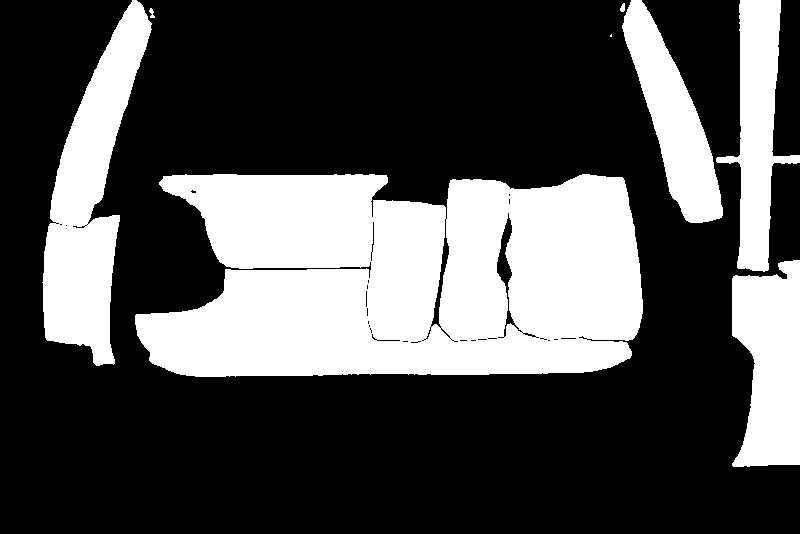

In [201]:
import numpy as np

# Initialize an array to hold the sum of all masks
combined_masks = np.zeros_like(masks2[0]['segmentation'])

# Sum all the masks
for mask in new_dict:
    combined_masks += mask['segmentation']

# Normalize to the range 0-255 for image display
combined_masks = (combined_masks / combined_masks.max() * 255).astype(np.uint8)

# Display the combined mask image
display(Image.fromarray(combined_masks).resize((width, height)))
